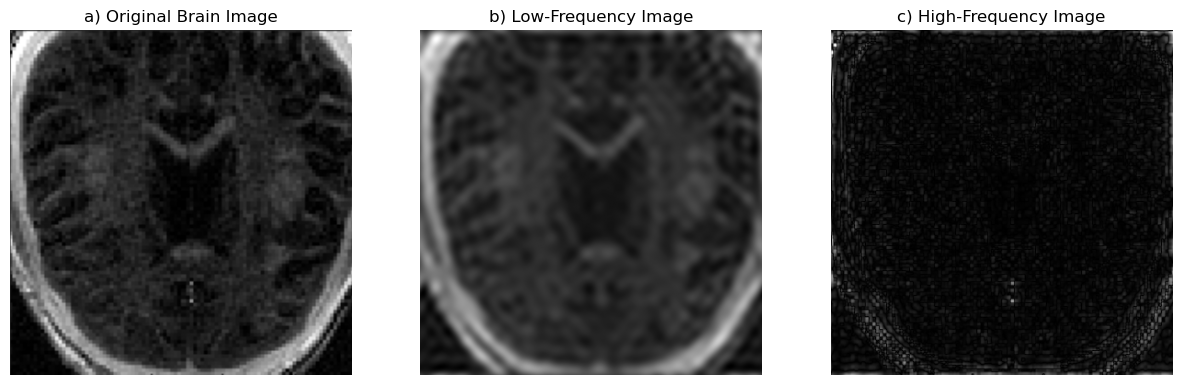

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from matplotlib.image import imread

# Load the image
brain_image = imread('brain.png')

# Ensure the image is in grayscale if it's RGB
if brain_image.ndim == 3:
    brain_image = np.mean(brain_image, axis=2)  # Convert to grayscale by averaging RGB channels

# Perform 2D Fourier Transform
image_freq = fft2(brain_image)
image_freq_shifted = fftshift(image_freq)  # Shift the zero frequency to the center

# Function to filter low or high frequencies
def filter_frequencies(image_freq_shifted, frequency_type='low', cutoff=20):
    rows, cols = image_freq_shifted.shape
    center_row, center_col = rows // 2, cols // 2
    filtered_freq = np.copy(image_freq_shifted)
    
    if frequency_type == 'low':
        # Zero out the high frequencies (outer parts) to retain low frequencies (center)
        filtered_freq[:center_row - cutoff, :] = 0  # Top part (high frequencies)
        filtered_freq[center_row + cutoff:, :] = 0  # Bottom part (high frequencies)
        filtered_freq[:, :center_col - cutoff] = 0  # Left part (high frequencies)
        filtered_freq[:, center_col + cutoff:] = 0  # Right part (high frequencies)
        
    elif frequency_type == 'high':
        # Zero out the low frequencies (center) to retain high frequencies (edges)
        filtered_freq[center_row - cutoff:center_row + cutoff, center_col - cutoff:center_col + cutoff] = 0  # Center part (low frequencies)
    
    return filtered_freq

# Apply the filters
# Low frequencies (retain center part)
low_freq_image = ifft2(fftshift(filter_frequencies(image_freq_shifted, 'low')))
# High frequencies (retain edges)
high_freq_image = ifft2(fftshift(filter_frequencies(image_freq_shifted, 'high')))

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axes[0].imshow(brain_image, cmap='gray')
axes[0].set_title("a) Original Brain Image")
axes[0].axis('off')

# Low-frequency filtered image
axes[1].imshow(np.abs(low_freq_image), cmap='gray')  # Take absolute value here
axes[1].set_title("b) Low-Frequency Image")
axes[1].axis('off')

# High-frequency filtered image
axes[2].imshow(np.abs(high_freq_image), cmap='gray')  # Take absolute value here
axes[2].set_title("c) High-Frequency Image")
axes[2].axis('off')
# Save the figure as a PNG file
plt.savefig('brain_comparison.png', dpi=1000)
plt.show()





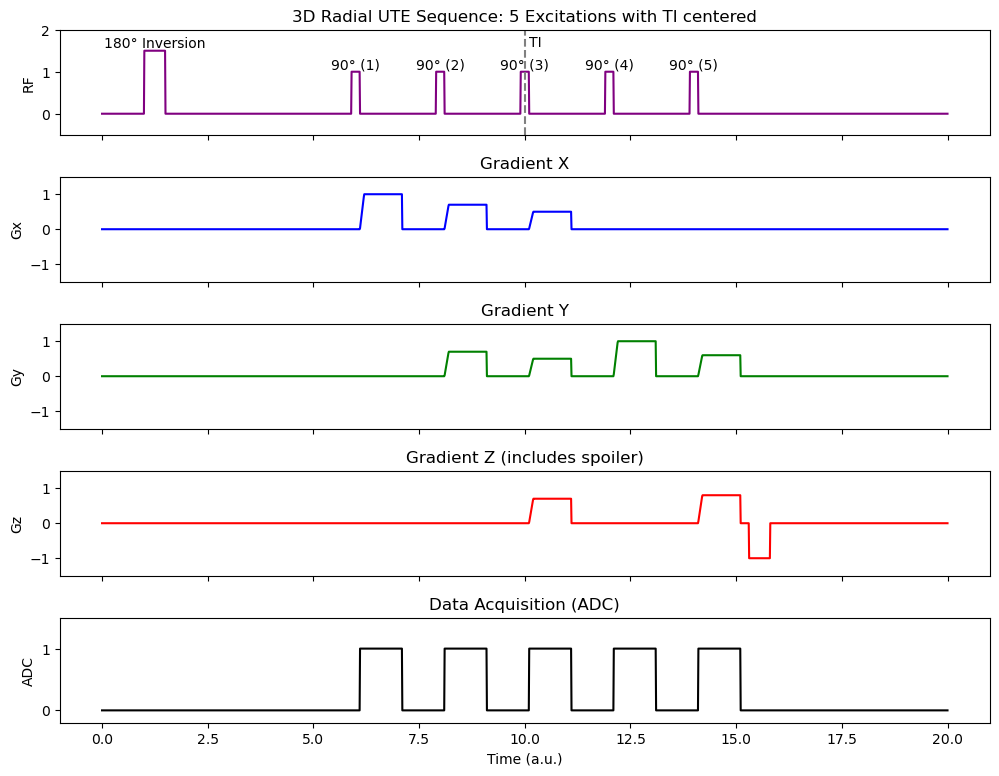

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Time setup
t = np.linspace(0, 20, 2000)  # more time to fit 5 pulses

# Timing parameters
inv_start, inv_end = 1, 1.5
num_exc = 5
exc_spacing = 2.0  # time between excitations
exc_dur = 0.2
readout_dur = 1.0
spoiler_dur = 0.5

# Calculate the total duration of the excitation window
total_exc_duration = (num_exc - 1) * exc_spacing + exc_dur  # Total duration of all excitations
start_time = (t[-1] - total_exc_duration) / 2  # Start time for the first excitation so TI is centered

# Calculate excitation pulse times so that TI is centered in the middle of all excitations
exc_starts = [start_time + i * exc_spacing for i in range(num_exc)]
exc_ends = [s + exc_dur for s in exc_starts]
readout_starts = exc_ends
readout_ends = [s + readout_dur for s in readout_starts]

# Inversion Time (TI) is centered on the entire excitation sequence
TI = (exc_starts[0] + exc_ends[-1]) / 2

# Spoiler after last readout
spoiler_start = readout_ends[-1] + 0.2
spoiler_end = spoiler_start + spoiler_dur

# RF waveform
rf = np.zeros_like(t)
rf[(t >= inv_start) & (t <= inv_end)] = 1.5  # inversion
for s, e in zip(exc_starts, exc_ends):
    rf[(t >= s) & (t <= e)] = 1.0

def radial_gradient(t_local, t0, t1, direction, ramp_duration=0.1):
    grad = np.zeros_like(t_local)
    mask = (t_local >= t0) & (t_local <= t1)  # Mask for the time window of the gradient
    
    # Ramp-up portion (linear increase from 0 to 1 during the ramp duration)
    ramp_mask = (t_local >= t0) & (t_local <= t0 + ramp_duration)
    ramp_t = t_local[ramp_mask] - t0
    ramp_waveform = ramp_t / ramp_duration  # Linear ramp from 0 to 1

    # Constant portion after ramp-up
    constant_mask = (t_local >= t0 + ramp_duration) & (t_local <= t1)
    constant_waveform = np.ones_like(t_local[constant_mask])  # Constant value after ramp-up
    
    # Full waveform (ramp then constant)
    full_waveform = np.zeros_like(t_local)
    full_waveform[ramp_mask] = ramp_waveform
    full_waveform[constant_mask] = constant_waveform

    # Apply the direction scaling and assign to the gradient (no oscillations)
    g = np.zeros((3, len(t_local)))
    for i in range(3):
        g[i][mask] = direction[i] * full_waveform[mask]  # Apply the direction for each component (x, y, z)
    
    return g

# Set up gradient arrays
Gx = np.zeros_like(t)
Gy = np.zeros_like(t)
Gz = np.zeros_like(t)

# Generate gradients for the excitations with rotating radial directions
directions = [
    [1, 0, 0],
    [0.7, 0.7, 0],
    [0.5, 0.5, 0.7],
    [0, 1, 0],
    [0, 0.6, 0.8],
]
for i in range(num_exc):
    gx, gy, gz = radial_gradient(t, readout_starts[i], readout_ends[i], directions[i])
    Gx += gx
    Gy += gy
    Gz += gz

# Add spoiler to Gz
spoiler_mask = (t >= spoiler_start) & (t <= spoiler_end)
Gz[spoiler_mask] += -1.0

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(12, 9), sharex=True)
plt.subplots_adjust(hspace=0.4)

# RF
axs[0].plot(t, rf, color='purple')
axs[0].set_ylabel("RF")
axs[0].set_ylim(-0.5, 2)
axs[0].annotate("180° Inversion", xy=((inv_start + inv_end)/2, 1.5), ha="center", va="bottom", fontsize=10)

for i in range(num_exc):
    axs[0].annotate(f"90° ({i+1})", xy=((exc_starts[i] + exc_ends[i])/2, 1.0), ha="center", va="bottom")
axs[0].axvline(x=TI, color='gray', linestyle='--')
axs[0].text(TI + 0.1, 1.6, "TI", fontsize=10)

# Gradients
axs[1].plot(t, Gx, color='blue')
axs[1].set_ylabel("Gx")
axs[1].set_ylim(-1.5, 1.5)

axs[2].plot(t, Gy, color='green')
axs[2].set_ylabel("Gy")
axs[2].set_ylim(-1.5, 1.5)

axs[3].plot(t, Gz, color='red')
axs[3].set_ylabel("Gz")
axs[3].set_ylim(-1.5, 1.5)

# Optional: ADC line (for data acquisition timing)
ADC = np.zeros_like(t)
for i in range(num_exc):
    ADC[(t >= readout_starts[i]) & (t <= readout_ends[i])] = 1
axs[4].plot(t, ADC, color='black')
axs[4].set_ylabel("ADC")
axs[4].set_xlabel("Time (a.u.)")
axs[4].set_ylim(-0.2, 1.5)

# Titles
axs[0].set_title(f"3D Radial UTE Sequence: {num_exc} Excitations with TI centered")
axs[1].set_title("Gradient X")
axs[2].set_title("Gradient Y")
axs[3].set_title("Gradient Z (includes spoiler)")
axs[4].set_title("Data Acquisition (ADC)")

plt.show()
